In [8]:
# Here is the imports
import os

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
FLAGS = ["final_recordbase"] # tensorboard, mixed_precision, final_recordbase
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import albumentations as A
if "mixed_precision" in FLAGS:
    print(f"PreTrain: Using Mixed Policy float16")
    keras.mixed_precision.set_global_policy('mixed_float16')
# keras.mixed_precision.set_global_policy('mixed_float16') normally this would provide extra speed for the model
# but in the case of 1660ti gpus they seem like they have tensor cores even they don't thus it slows down the model use this on higher powered models
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras.models import load_model

In [9]:
# Dataset Constants
DATASET_PATH = "./final_recordbase"
TEST_DIR = "val"
BATCH_SIZE = 1
LR = 0.0001

RECORD_ENCODING_TYPE = "ZLIB" # none if no encoding is used

MODEL_LOAD_TYPE = 'weights' # model or weights
#MODEL_LOAD_TYPE = 'weights' # model or weights
MODEL_WEIGHT_PATH = "./models/all_time_best/best.h5"
#MODEL_WEIGHT_PATH = "./models/10_09-01_27/best_01_27_10_09.h5"
#MODEL_WEIGHT_PATH = "./models/18_09-00_40-focal_lovasz_unet/best.h5"
#MODEL_WEIGHT_PATH = "./models/19_09-00_31-focal_lovasz_weight_1_lr_510e5/epoch_50.h5"


# Variables
test_dir = os.path.join(DATASET_PATH, TEST_DIR)

test_filenames = tf.io.gfile.glob(f"{test_dir}/*.tfrecords")


In [10]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [11]:
def aug_fn(image):
    transforms = A.Compose([
            A.Rotate(limit=40),
            A.Flip(),
            ])
    aug_data = transforms(image=image)
    aug_img = aug_data["image"]
    return aug_img

def preprocessing_fn(image):
    image = image.astype("float32")
    return image

def parse_examples_batch(examples):
    feature_description = {
        'image' : tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.float32)
    }
    samples = tf.io.parse_example(examples, feature_description)
    return samples

def prepare_sample(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image"])
    label = features["label"]
    image = tf.vectorized_map(lambda x: tf.numpy_function(func=preprocessing_fn, inp=x, Tout=(tf.float32)), [image])
    return image, label

def prepare_sample_aug(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image"])
    label = features["label"]
    image = tf.vectorized_map(lambda x: tf.numpy_function(func=aug_fn, inp=x, Tout=(tf.uint8)), [image])
    image = tf.vectorized_map(lambda x: tf.numpy_function(func=preprocessing_fn, inp=x, Tout=(tf.float32)), [image])
    return image, label

def get_dataset_optimized(filenames, batch_size, shuffle_size, augment=True):
    record_dataset = tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
    if shuffle_size > 0:
        record_dataset = record_dataset.shuffle(shuffle_size)
    record_dataset = (record_dataset
                    .batch(batch_size=batch_size)
                    .map(map_func=parse_examples_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE))
    if augment:
        record_dataset = record_dataset.map(map_func=prepare_sample_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        record_dataset = record_dataset.map(map_func=prepare_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return record_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = get_dataset_optimized(test_filenames, BATCH_SIZE, 0, augment=False)

In [6]:
model = load_model(MODEL_WEIGHT_PATH)

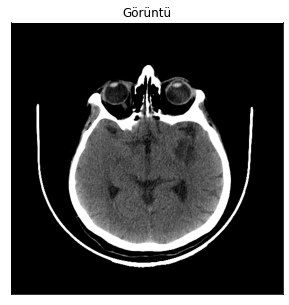

Ground truth True | Prediction False


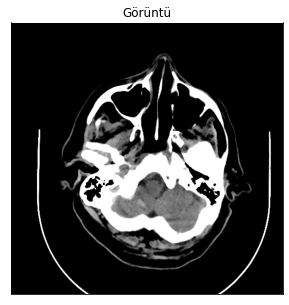

Ground truth True | Prediction False


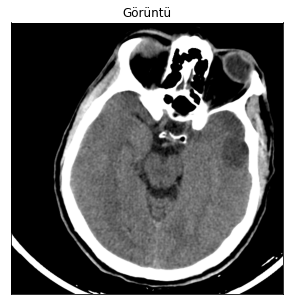

Ground truth True | Prediction False


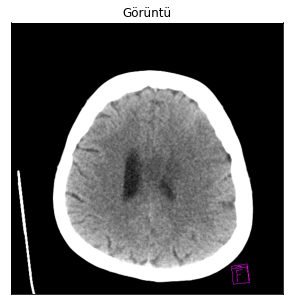

Ground truth True | Prediction False


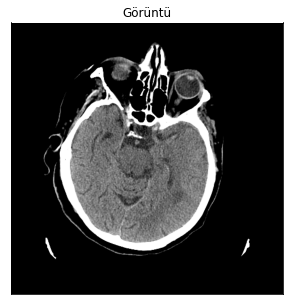

Ground truth True | Prediction False


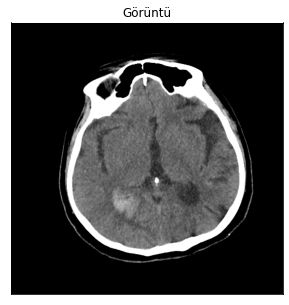

Ground truth True | Prediction False


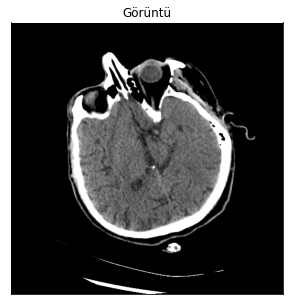

Ground truth True | Prediction False


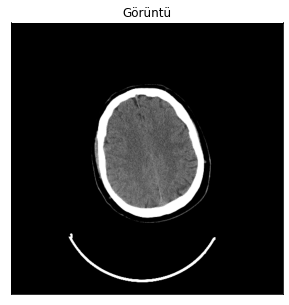

Ground truth True | Prediction False


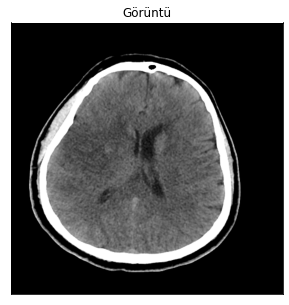

Ground truth True | Prediction False


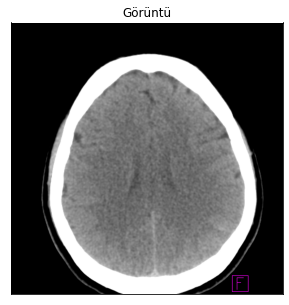

Ground truth True | Prediction False
FP 0 | FN 10


In [13]:
n = 150
n // BATCH_SIZE
test = test_dataset.take(n)
fp = 0
fn = 0
for i in test:
    for k in range(0, BATCH_SIZE):
        image = i[0][k].numpy()
        gt = i[1][k].numpy()
        image = np.expand_dims(image, axis=0)
        prediction = model.predict(image)
        if "final_recordbase" in FLAGS:
            if (gt>0.5) != (prediction[0, 0] > 0.5):
                visualize(
                    Görüntü=denormalize(image.squeeze())
                )
                if gt > 0.5:
                    fn += 1
                else:
                    fp += 1
                print(f"Ground truth {gt>0.5} | Prediction {prediction[0, 0]>0.5}")
        else:
            if (gt<0.5) != (prediction[0, 0] < 0.5):
                visualize(
                    Görüntü=denormalize(image.squeeze())
                )
                if gt < 0.5:
                    fn += 1
                else:
                    fp += 1
                print(f"Ground truth {gt<0.5} | Prediction {prediction[0, 0]<0.5}")
print(f"FP {fp} | FN {fn}")
